# 目的
在USPS(手寫數字0-9)資料集  
使用High Order SVD (HOSVD)來辨識  

SVD: Singular Value Decomposition

HOVSD is related to the Tucker model in psychometrics and chemometrics.

In [1]:
import numpy as np #array
import pandas as pd #dataframe
from pathlib import Path #file path
from tqdm.notebook import trange, tqdm #for loop run progress

In [2]:
import matplotlib
import matplotlib.pyplot as plt

In [3]:
import tensorly as tl

In [4]:
# Environment 
from platform import python_version
print('Python Version: ', python_version())
print('Numpy Version: ', np.__version__)
print('Pandas Version: ', pd.__version__)
print('Matplotlib Version: ', matplotlib.__version__)
print('TensorLy Version: ', tl.__version__)

Python Version:  3.9.9
Numpy Version:  1.22.0
Pandas Version:  1.3.5
Matplotlib Version:  3.5.1
TensorLy Version:  0.7.0


# Data

USPS dataset | Kaggle  
[https://www.kaggle.com/bistaumanga/usps-dataset](https://www.kaggle.com/bistaumanga/usps-dataset)  
Handwritten Digits USPS dataset.  

The dataset has 7291 train and 2007 test images. The images are 16*16 grayscale pixels.  

The dataset is given in hdf5 file format, the hdf5 file has two groups train and test and each group has two datasets: data and target.  

To read this file:  

```
import h5py
with h5py.File(path, 'r') as hf:
        train = hf.get('train')
        X_tr = train.get('data')[:]
        y_tr = train.get('target')[:]
        test = hf.get('test')
        X_te = test.get('data')[:]
        y_te = test.get('target')[:]

```

In [6]:
import h5py
with h5py.File(Path('input','usps.h5'), 'r') as hf:
        train = hf.get('train')
        X_tr = train.get('data')[:]
        y_tr = train.get('target')[:]
        test = hf.get('test')
        X_te = test.get('data')[:]
        y_te = test.get('target')[:]

In [7]:
df_train = pd.concat([pd.DataFrame(X_tr),
                      pd.DataFrame(y_tr, columns=['Label'])], axis=1)

In [18]:
df_train.shape

(7291, 257)

In [8]:
df_test = pd.concat([pd.DataFrame(X_te),
                     pd.DataFrame(y_te, columns=['Label'])], axis=1)

In [14]:
df_test.shape

(2007, 257)

# HOSVD  
1. 先將 training set 整理成 0-9 各自一個 set (tensor: 16 x 16 x 圖片數量)  
2. 將 step1 得到的 0-9 set，分別做 hosvd 取得所需的 U1, U2, U3, S  
3. 將 testing set 每一張手寫數字 (z)，與 step 2 所得到 0-9 U1 U2 S，取特定 j 值所得的 Aj  
依照以下公式，算出對 0-9 各別的 G 值  

    - HOSVD  
$A_j=S(:,:,j)~\times_1~U^{(1)}~\times_2~U^{(2)}$

    - Solve least squares problem：  
    $\underset{z}{\min}||Z-\sum_j z_j A_j||_F$  

    - Put  
    $G(z)={1 \over 2}\langle Z,Z\rangle -\sum_j\langle Z,A_j\rangle + {1 \over 2}\sum_j z_j^2\langle A_j,A_j\rangle$

    - To find the minimum  
    $z_j={\langle Z,A_j\rangle\over\langle A_j,A_j\rangle}$

4. 當中最小的 G 值，即為預測該張手寫數字所代表的數字

In [9]:
tensor_train = {}

for i in range(10):
    df_label = df_train[df_train['Label']==i].copy().reset_index(drop=True)
    tensor = np.array(df_label.drop('Label', axis=1).transpose()).reshape(16,16,df_label.shape[0])
    
    tensor_train[i] = tensor

In [10]:
from tensorly.decomposition import tucker

core_dict = {}
factors_dict = {}

for i in range(10):
    core_dict[i], factors_dict[i] = tucker(tensor_train[i], rank=tensor_train[i].shape)

In [11]:
# Solve least squares problem：  
# $\underset{z}{\min}||Z-\sum_j z_j A_j||_F$  
# To find the minimum  
# $z_j={\langle Z,A_j\rangle\over\langle A_j,A_j\rangle}$

df_test_HOSVD_k = df_test.copy()

select_k_list = np.arange(21)

for k in trange(len(select_k_list)):
    k_value = select_k_list[k]
    df_test_HOSVD_k[f'k{str(k_value).zfill(2)}_Predict'] = 0
    
    for n in range(df_test.shape[0]):
        z_array = df_test.drop('Label', axis=1).iloc[n,:]
        Z = np.array(z_array).reshape(16,16)
        G_list = []
        for d in range(10):
            S = core_dict[d]
            U1,U2,U3 = factors_dict[d]
            
            Aj = U1.dot(S[:,:,k_value]).dot(U2.T)
            zj = tl.tenalg.inner(Z, Aj)/tl.tenalg.inner(Aj, Aj)
            
            G = np.linalg.norm(np.subtract(Z, zj*Aj), ord='fro')
            
            G_list.append(G)
            
        df_test_HOSVD_k.loc[n, f'k{str(k_value).zfill(2)}_Predict'] = np.argmin(G_list)

  0%|          | 0/21 [00:00<?, ?it/s]

In [13]:
# Compare if Success i.e. Label==Predict
for k in trange(len(select_k_list)):
    k_value = select_k_list[k]
    
    df_test_HOSVD_k[f'k{str(k_value).zfill(2)}_Success'] = 0
    
    for n in range(df_test_HOSVD_k.shape[0]):
        if df_test_HOSVD_k.loc[n, 'Label'] == df_test_HOSVD_k.loc[n, f'k{str(k_value).zfill(2)}_Predict']:
            df_test_HOSVD_k.loc[n, f'k{str(k_value).zfill(2)}_Success'] = 1

  0%|          | 0/21 [00:00<?, ?it/s]

In [15]:
# Display and Compare best k for Accuracy
df_HOSVD_k_accuracy = pd.DataFrame(columns=['k','Success','Accuracy'], 
                                   index=np.arange(len(select_k_list)))

for k in trange(len(select_k_list)):
    k_value = select_k_list[k]
    df_HOSVD_k_accuracy.loc[k, 'k'] = k_value
    df_HOSVD_k_accuracy.loc[k, 'Success'] = df_test_HOSVD_k[f'k{str(k_value).zfill(2)}_Success'].sum()
    df_HOSVD_k_accuracy.loc[k, 'Accuracy'] = (df_HOSVD_k_accuracy.loc[k, 'Success']/df_test_HOSVD_k.shape[0])*100

  0%|          | 0/21 [00:00<?, ?it/s]

In [16]:
df_HOSVD_k_accuracy

,k,Success,Accuracy
0,0,1619,80.667663
1,1,501,24.962631
2,2,312,15.54559
3,3,248,12.356751
4,4,137,6.826109
5,5,160,7.972098
6,6,128,6.377678
7,7,112,5.580468
8,8,79,3.936223
9,9,111,5.530643


Text(0.5, 1.0, 'HOSVD Accuracy vs k value')

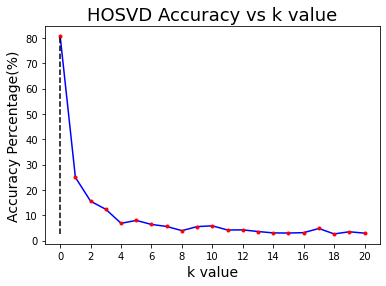

In [17]:
plt.figure(figsize=(6,4))
plt.plot(df_HOSVD_k_accuracy['k'], df_HOSVD_k_accuracy['Accuracy'], 'b-')
plt.plot(df_HOSVD_k_accuracy['k'], df_HOSVD_k_accuracy['Accuracy'], 'r.')
plt.vlines(df_HOSVD_k_accuracy.loc[np.argmax(df_HOSVD_k_accuracy['Accuracy']),'k'],
           ymin=df_HOSVD_k_accuracy['Accuracy'].min(),
           ymax=df_HOSVD_k_accuracy['Accuracy'].max(),
           linestyles='dashed',colors='black')
plt.hlines(df_HOSVD_k_accuracy['Accuracy'].max(),
           xmin=df_HOSVD_k_accuracy['k'].min(),
           xmax=df_HOSVD_k_accuracy.loc[np.argmax(df_HOSVD_k_accuracy['Accuracy']),'k'],
           linestyles='dashed',colors='black')
plt.xlabel('k value', fontsize=14)
# plt.xticks(np.array(df_k_accuracy['k'], dtype=int))
plt.xticks(np.arange(0,21,2))
plt.ylabel('Accuracy Percentage(%)', fontsize=14)
plt.title('HOSVD Accuracy vs k value', fontsize=18)
# plt.savefig('HOSVD_k_Accuracy.jpg', dpi=300)